# Mitosis Detector Notebook

Import libraries and mount google drive

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time
from google.colab import drive

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [2]:
!unzip -q "/content/drive/MyDrive/mitosis_detector_BTTAI/dataset_root.zip" -d "/content/dataset_root"

Configure paths and parameters

In [12]:
BASE_PATH = '/content/drive/MyDrive/mitosis_detector_BTTAI/BTTAI Mitosis Classifier Project - Andres Figueroa'

DATA_DIR = '/content/dataset_root/dataset_root'
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'best_mitosis_model.pth')
PLOT_SAVE_PATH = os.path.join(BASE_PATH, 'training_curves.png')

BATCH_SIZE = 32
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 50
RANDOM_SEED = 123
PATIENCE = 10

torch.manual_seed(RANDOM_SEED)

In [13]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=None)

IMG_SIZE = 224
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Data augmentation for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    normalize,
])

# Only resizing and normalization for validation and test sets
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    normalize,
])

# Load the full dataset from the directory structure
print(f"Loading data from: {DATA_DIR}")
full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes
print(f"Found {len(full_dataset)} images belonging to {len(class_names)} classes: {class_names}")

# Define split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply the transformations
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loading data from: /content/dataset_root/dataset_root
Found 26350 images belonging to 2 classes: ['1', '2']
Training samples: 18445
Validation samples: 5270
Test samples: 2635


Model definition

In [14]:
def get_model(num_classes=2):
    # Load the pre-trained DeepLabV3 model with a ResNet-101 backbone
    model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    for param in model.backbone.layer4.parameters():
        param.requires_grad = True

    # Replace the classifier head with a new sequence for classification
    model.classifier = nn.Sequential(
        nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Conv2d(256, num_classes, kernel_size=1, stride=1),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(start_dim=1)
    )

    # Unfreeze the parameters of the new classifier head so they can be trained
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

model = get_model(num_classes=len(class_names))
model = model.to(device)

print("Model architecture loaded and modified for transfer learning.")

Model architecture loaded and modified for transfer learning.


Training and Validation Cycle

In [15]:
# Import the scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss function
criterion = nn.CrossEntropyLoss()


# We pass only the parameters that we want to train (unfrozen)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY)

# This will reduce the LR when validation loss stops improving
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


# Variables for training history and Early Stopping
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf') # We want to minimize validation loss
epochs_no_improve = 0

acc = []

print("Starting model training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    #Training
    model.train()
    running_train_loss = 0.0
    print(f"Starting Epoch {epoch+1}")
    for i, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {i+1}: Loading data...")
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        features = model.backbone(inputs)['out']
        outputs = model.classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    history['train_loss'].append(epoch_train_loss)

    #Validation
    model.eval()
    running_val_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            features = model.backbone(inputs)['out']
            outputs = model.classifier(features)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc = correct_predictions.double() / len(val_dataset)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")
    acc.append(epoch_val_acc)

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save a full checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, MODEL_SAVE_PATH)
        print(f"New best model saved to {MODEL_SAVE_PATH} with Val Loss: {best_val_loss:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Val Loss for {epochs_no_improve} epochs.")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"Training finished in {training_time:.2f} minutes.")

Streaming output truncated to the last 5000 lines.
Batch 222: Loading data...
Batch 223: Loading data...
Batch 224: Loading data...
Batch 225: Loading data...
Batch 226: Loading data...
Batch 227: Loading data...
Batch 228: Loading data...
Batch 229: Loading data...
Batch 230: Loading data...
Batch 231: Loading data...
Batch 232: Loading data...
Batch 233: Loading data...
Batch 234: Loading data...
Batch 235: Loading data...
Batch 236: Loading data...
Batch 237: Loading data...
Batch 238: Loading data...
Batch 239: Loading data...
Batch 240: Loading data...
Batch 241: Loading data...
Batch 242: Loading data...
Batch 243: Loading data...
Batch 244: Loading data...
Batch 245: Loading data...
Batch 246: Loading data...
Batch 247: Loading data...
Batch 248: Loading data...
Batch 249: Loading data...
Batch 250: Loading data...
Batch 251: Loading data...
Batch 252: Loading data...
Batch 253: Loading data...
Batch 254: Loading data...
Batch 255: Loading data...
Batch 256: Loading data...
Batc

Evaluation on the Test Set

Evaluating model on the test set...
Accuracy:  0.8091
Precision: 0.8022
Recall:    0.7805
F1-Score:  0.7912


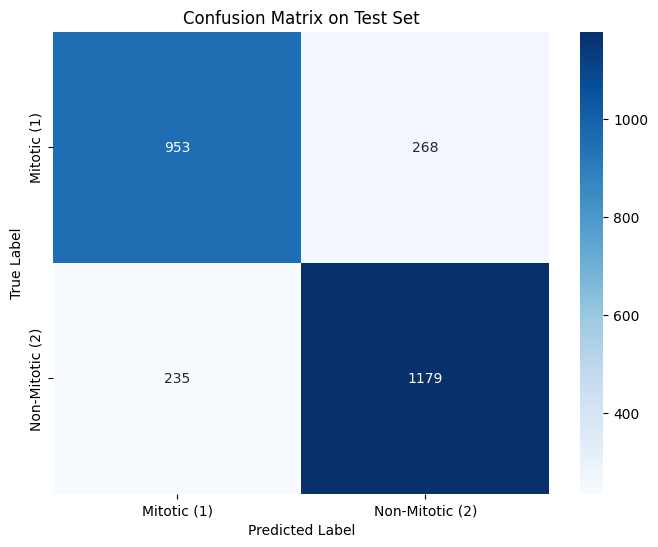

In [16]:
print("Evaluating model on the test set...")

model = get_model(num_classes=len(class_names)).to(device)
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        features = model.backbone(inputs)['out']
        outputs = model.classifier(features)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
precision = precision_score(all_labels, all_preds, average='binary', pos_label=0) # '0' is mitotic
recall = recall_score(all_labels, all_preds, average='binary', pos_label=0)
f1 = f1_score(all_labels, all_preds, average='binary', pos_label=0)

print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mitotic (1)', 'Non-Mitotic (2)'],
            yticklabels=['Mitotic (1)', 'Non-Mitotic (2)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()